### In this notebook, we take our "Scratch Engine" to a real test. We are going to teach the computer to read handwritten digits.

In the earlier notebooks, we solved
**XOR** with 2 inputs --> to get 1 output
Now in **MNIST** we have 784 inputs (28 * 28 Pixels) --> 10 outputs (Digits 0-9).

### Loading and Preparing Data

Since images are just arrays of numbers, we need to "Flatten" them. A 28x28 square becomes a single line of 784 numbers.

ActivationFunction Class defined successfully!


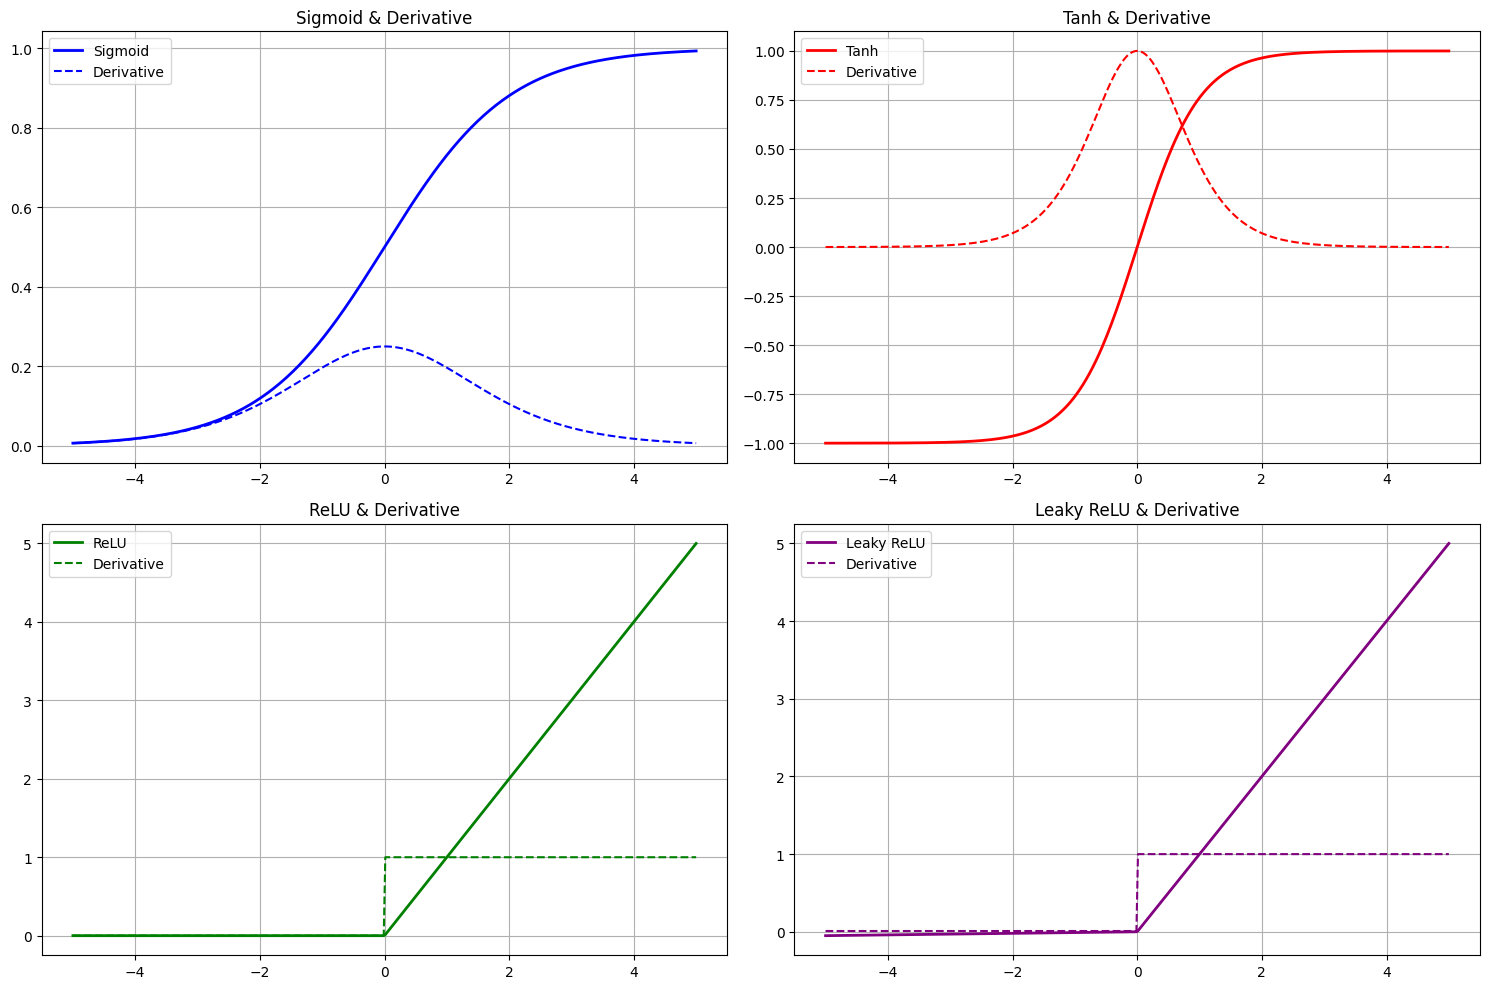

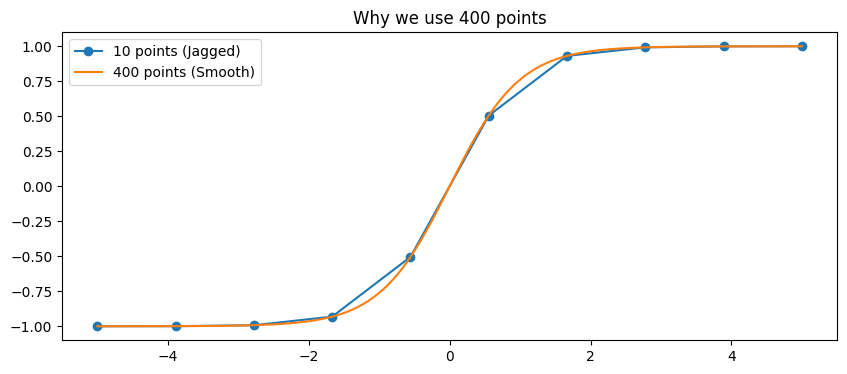

Output of Forward Pass:
 [[0.11291276]
 [0.        ]]


TypeError: Layer.backward() got an unexpected keyword argument 'learning_rate'

In [1]:
import import_ipynb
import ActivationFunctions2
import FowardBackwardPropagation3
import LossFunctions4
import Optimizers5
import Complete_Framework6

from ActivationFunctions2 import ActivationFunction
from LossFunctions4 import Loss
from Optimizers5 import SGD, Adam
from FowardBackwardPropagation3 import Layer
from Complete_Framework6 import NeuralNetwork

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
print("Downloading MNIST...")
mnist_input = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist_input)
# X, y= mnist_input.data, mnist_input.target

In [ ]:
X, y = mnist_input.data, mnist_input.target
y = y.astype(int)

In [ ]:
X.size, y.size, y

1. The Output (y): The "Class" (0 to 9)

When you see 0-9 in the "class" column, that is your Target.

It tells the computer: "This specific image is a 5."
There are 10 possible classes because there are 10 digits in the human language (0, 1, 2, 3, 4, 5, 6, 7, 8, 9).

2. The Input (X): The "Pixels" (0 to 255)

When you see the features labeled pixel1, pixel2 ... pixel784, those are the locations on the 28x28 grid.
But the value stored inside those pixels is the "brightness."

In computer science, standard grayscale images use 8-bit color depth.
1. 0 = Pitch Black
3. 255 = Pure White
Any number in between (like 127) is a shade of Gray.

In [ ]:
X[0].max(), X[0].min()

### Why do we divide by 255? (The "Why" of Normalization)

Neural networks are very sensitive to the scale of the input numbers.
If your input is 255 and your weight is 0.1, the result is 25.5.
If your input is 1, and your weight is 0.1, the result is 0.1.
When numbers are as large as 255, the "Sigmoid" and "ReLU" functions can get "saturated" (pushed to the very edge) very quickly. This makes the gradients extremely large or extremely small, causing the model to crash or stop learning.

By dividing by 255, we turn every pixel into a decimal between 0.0 and 1.0.
0 becomes 0.0
127 becomes 0.49
255 becomes 1.0

This "squishing" of the data makes the math much more stable and helps the model converge (find the answer) significantly faster.

In [ ]:
# Normalize: Pixels are 0-255. Neural networks love 0-1.
X = X / 255.0

1. The "Why": Comparison Problem
Imagine our model's output layer. It has 10 neurons (one for each digit 0-9).

When we show the model a picture of a "3", the output neurons might look like this:
Neuron 0: 0.01
Neuron 1: 0.02
Neuron 2: 0.05
Neuron 3: 0.85 <-- (The model thinks it's this!)
Neuron 4: 0.01
... (and so on)

The output is a Vector (list of 10 numbers).
However, your "True Label" is just a Single Number (3).
You cannot mathematically subtract a single number (3) from a list of 10 numbers. To calculate the "Error" (Loss), both the prediction and the truth must be the same shape.
One-Hot Encoding turns the number 3 into a list that looks exactly like the model's output: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Now the math is easy:
Error = [0.01, 0.02, 0.05, 0.85, ...] minus [0, 0, 0, 1, ...]

In [ ]:
def one_hot(y):
    # 1. Creating a matrix of zeros. 
    # If we have 1000 images, it creates 1000 rows and 10 columns.
    print(f"y.size: {y.size}")
    oh = np.zeros((y.size, 10))
    print(f"After the one hot encoder: {oh}")
    # 2. Advanced Indexing (The "Magic" line)
    # np.arange(y.size) selects every row (0, 1, 2, 3...)
    # y selects the column based on the digit (e.g., column 3 if y=3)
    oh[np.arange(y.size), y] = 1
    print(f"After the advanced indexing: {oh}")
    
    # 3. Transpose
    # Our framework expects features/classes in ROWS, so we flip it.
    return oh.T

In [ ]:
# 4. Split and Transpose
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.T
y_train = one_hot(y_train)
X_test = X_test.T
y_test = one_hot(y_test)

print(f"Data Loaded. Training shape: {X_train.shape}") # Should be (784, 56000)

### Re-Explaining the Syntax: oh[np.arange(y.size), y] = 1

Let's look at the "Grammar" of this line. In NumPy, when you have a 2D array, the square brackets [row, column] work like this:
The First Part: np.arange(y.size)
This represents the Rows.

If you have 70,000 images, this is just a list: [0, 1, 2, 3, ... 69999].

It tells NumPy: "I am going to talk to every single row, one by one."
The Second Part: y
This represents the Columns.

Since y is now a list of integers (the actual digits), it tells NumPy: "In each row, go to the column number that matches the digit."
Putting it together:

oh[row_list, column_list] = 1
If the first 3 labels in y are [5, 0, 4], NumPy does this:

Row 0, Col 5 = 1

Row 1, Col 0 = 1

Row 2, Col 4 = 1

In [ ]:
np.set_printoptions(threshold=1000)

In [ ]:
y_train[0]

### Step 2: Training the "Deep" Model
For MNIST, we need more "brain power." We will use 128 hidden neurons.

Important: We will use Adam (the Tesla of optimizers) because 784 weights is too much for simple SGD to handle quickly.

In [ ]:
# Define Architecture
# Input(784) -> Hidden(128, ReLU) -> Output(10, Sigmoid)
mnist_nn = NeuralNetwork(Loss.binary_cross_entropy, Loss.bce_derivative, Adam(learning_rate=0.001))

mnist_nn.add_layer(Layer(784, 128, ActivationFunction.relu, ActivationFunction.relu_derivative))
mnist_nn.add_layer(Layer(128, 10, ActivationFunction.sigmoid, ActivationFunction.sigmoid_derivative))

# Training on a subset first to save time
# We use 10,000 images out of 56,000
print("Training on 10,000 images...")
mnist_nn.train(X_train[:, :10000], y_train[:, :10000], epochs=100, learning_rate=0.001)

Training on 10,000 images...
<string>:10: RuntimeWarning: overflow encountered in exp
<string>:14: RuntimeWarning: overflow encountered in exp
Epoch 0/100 - Loss: 13.6846

Why are we getting this error? Because we have defined the Layer formula wrong in Forward and backward propagation


This is a "Right of Passage" in Deep Learning! You have just encountered the Exploding Gradient Problem.

🔍 What is happening?

Overflow in exp: Your input values (Z) are getting so large (positive or negative) that e^x is reaching "Infinity" as far as the computer is concerned.

High Loss (13.68): A "random guess" loss for this problem should be around 0.69 or 2.3 (depending on the math). A loss of 13.68 means your model is "Confident but Wrong." It is predicting 0.9999 for the wrong digit.

🛠️ The Fix: "The Stability Patch"

To solve this, we need to do two things: Initialize weights properly and Clip our Sigmoid function.

1. Better Weight Initialization (Xavier/He Initialization)
In your Layer class, you are likely using np.random.randn(...) * 0.1.
Because MNIST has 784 inputs, adding up 784 random numbers makes the result (Z) huge.
Update your Layer class __init__ to this:
code
Python

### Instead of * 0.1, use this formula (Xavier Initialization):

self.W = np.random.randn(output_size, input_size) * np.sqrt(1. / input_size)

self.b = np.zeros((output_size, 1))

2. Stable Sigmoid
We need to stop exp(-x) from blowing up when x is a very large negative number.
Update your ActivationFunction.sigmoid to this:
code
Python
@staticmethod
def sigmoid(x):
    # Clip x to stay between -500 and 500 so exp(x) doesn't overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))